<a href="https://colab.research.google.com/github/ellizeurs/Compactacao-de-Sinais-PCD/blob/master/PCD_(alternativo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

In [61]:
def plot_data(x, y):
    n_dims = x.shape[1]  # Determina a dimensão dos dados

    if n_dims == 1:  # Plot 1D
        plt.figure(figsize=(8, 6))
        for i, category in enumerate(np.unique(y)):
            plt.scatter(x[y == category], np.full(np.sum(y == category), 0), label=f'Category {category}')
        plt.xlabel('Valor de X')
        plt.ylabel('Categoria')
        plt.title('Plot dos Dados X com Categorias')
        plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
        plt.legend()
        plt.grid(True)
        plt.show()

    elif n_dims == 2:  # Plot 2D
        plt.figure(figsize=(8, 6))
        for i, category in enumerate(np.unique(y)):
            plt.scatter(x[y == category][:, 0], x[y == category][:, 1], label=f'Category {category}')
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.title('Plot dos Dados X e Y com Categorias')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif n_dims == 3:  # Plot 3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        for i, category in enumerate(np.unique(y)):
            ax.scatter(x[y == category][:, 0], x[y == category][:, 1], x[y == category][:, 2], label=f'Category {category}')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.title('Plot dos Dados X, Y e Z com Categorias')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("Não é possível plotar dados com mais de 3 dimensões.")

In [62]:
# Carregar o conjunto de dados Iris
iris = load_iris()
X = iris.data
y = iris.target

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
class PcdModel():
    def __init__(self, input_shape, seed_value, verbose=False):
        self.models = {}
        self.components_weights = {}
        self.input_shape = input_shape
        self.seed_value = seed_value
        self.verbose = verbose

    def get_model(self, n_component):
        if self.verbose:
            print('Building model')
        if n_component in self.models:
            return self.models[n_component]

        img = tf.keras.layers.Input(shape=self.input_shape)
        to_be_concatenated_layers = []

        if n_component != 1:
            # Adding already trained layers
            if self.verbose:
                print('Adding old components')
            for i in range(1, n_component):
                component_layer = tf.keras.layers.Dense(
                    1,
                    kernel_initializer=tf.keras.initializers.he_normal(seed=self.seed_value),
                    bias_initializer=tf.keras.initializers.zeros(),
                    activation="relu"
                )(img)
                to_be_concatenated_layers.append(component_layer)

        # Adding new layer
        if self.verbose:
            print('Adding new component')
        component_layer = tf.keras.layers.Dense(
            1,
            kernel_initializer=tf.keras.initializers.he_normal(seed=self.seed_value),
            bias_initializer=tf.keras.initializers.zeros(),
            activation="relu"
        )(img)
        to_be_concatenated_layers.append(component_layer)

        # Actually "classification" part
        if len(to_be_concatenated_layers) > 1:
            concat = tf.keras.layers.Concatenate()(to_be_concatenated_layers)
            flatten = tf.keras.layers.Flatten()(concat)
        else:
            flatten = tf.keras.layers.Flatten()(component_layer)

        dense_layer_2 = tf.keras.layers.Dense(3, activation='softmax')(flatten)

        # Creating model
        self.models[n_component] = tf.keras.models.Model(img, dense_layer_2)

        if n_component != 1:
            # Freezing
            if self.verbose:
                print('Freezing')
            for i in range(1, n_component):
                self.models[n_component].layers[i].set_weights(self.components_weights[i])
                self.models[n_component].layers[i].trainable = False
        if self.verbose:
            print('Model built')
        return self.models[n_component]

    def update_weights(self, n_component):
        # Saving weight
        self.components_weights[n_component] = self.models[n_component].layers[n_component].get_weights()

    def transform(self, X, n_component):
        model = self.models[n_component]
        hidden_layers_outputs = []
        for i in range(1, n_component + 1):
            layer_output = tf.keras.backend.function([model.input], [model.layers[i].output])
            hidden_layers_outputs.append(layer_output([X])[0])
        return np.concatenate(hidden_layers_outputs, axis=1)

In [64]:
# Função para calcular as métricas
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test).argmax(axis=1)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    return metrics

1/1 [==============================] - 0s 47ms/step
Component 1: {'accuracy': 0.7, 'precision': 0.5166666666666667, 'recall': 0.6666666666666666, 'f1_score': 0.5698924731182796}


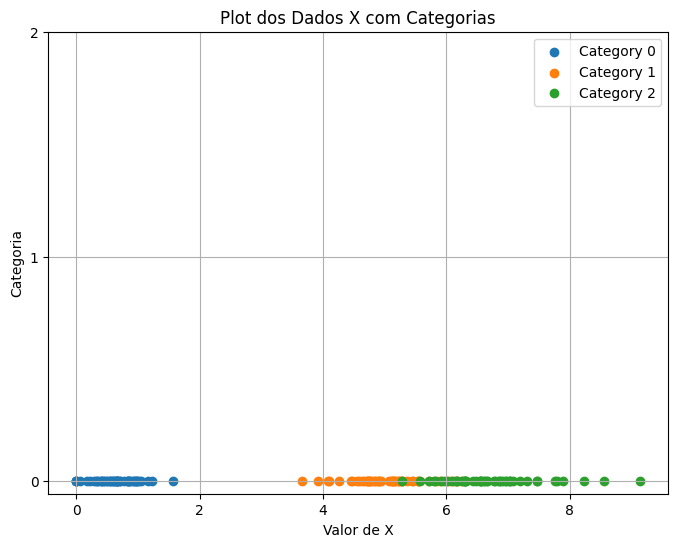

1/1 [==============================] - 0s 55ms/step
Component 2: {'accuracy': 0.4, 'precision': 0.2232854864433812, 'recall': 0.3703703703703704, 'f1_score': 0.2777777777777778}


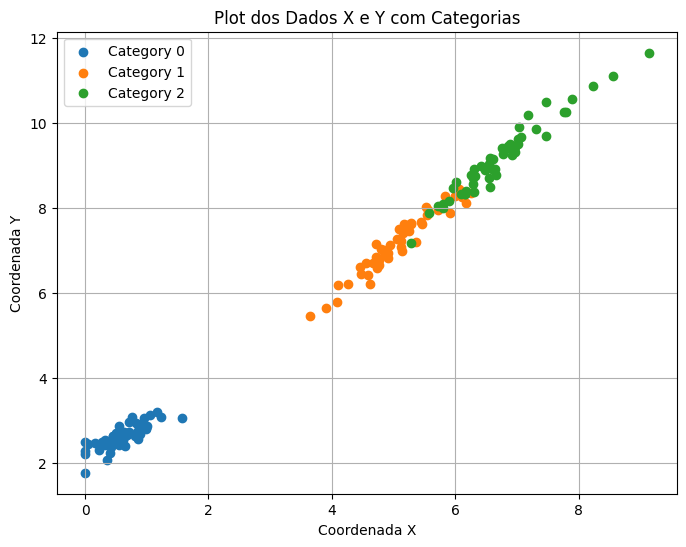

1/1 [==============================] - 0s 63ms/step
Component 3: {'accuracy': 0.9, 'precision': 0.9285714285714285, 'recall': 0.8888888888888888, 'f1_score': 0.8933333333333334}


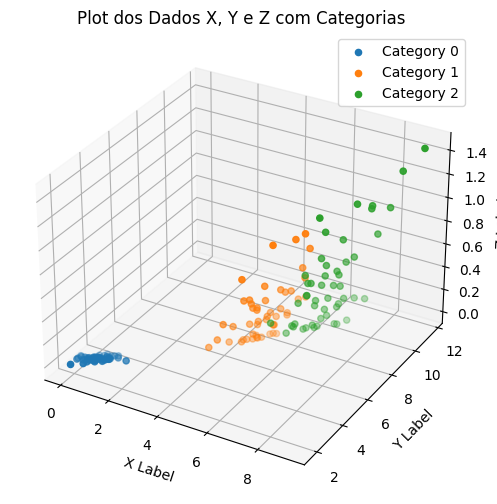

1/1 [==============================] - 0s 69ms/step
Component 4: {'accuracy': 0.9333333333333333, 'precision': 0.9487179487179488, 'recall': 0.9259259259259259, 'f1_score': 0.9305555555555555}
1/1 [==============================] - 0s 72ms/step
Component 5: {'accuracy': 0.9, 'precision': 0.9027777777777778, 'recall': 0.8956228956228957, 'f1_score': 0.8976982097186701}


In [67]:
# Treinamento e avaliação
n_components = 5  # Número de componentes PCD
input_shape = (X_train.shape[1],)
seed_value = 10

pcd_model = PcdModel(input_shape, seed_value)

for i in range(1, n_components + 1):
    model = pcd_model.get_model(i)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    pcd_model.update_weights(i)
    metrics = calculate_metrics(model, X_test, y_test)
    print(f'Component {i}: {metrics}')
    if i <= 3:
      X_pcd = pcd_model.transform(X, i)
      plot_data(X_pcd, y)